In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
# LBM D2Q9 lattice scheme configuration
##############
#  6   2   5
#   \  |  /
# 3 —— 0 —— 1
#   /  |  \
#  7   4   8
##############

Nq = 9  # Number of lattice directions
Nx = 16  # Number of grid points in x-direction
Ny = 16  # Number of grid points in y-direction
Nt = 31  # Number of timesteps

# Lattice vector definition
ei = jnp.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
ci = jnp.array([[0, 1, 0, -1, 0, 1, -1, -1, 1], 
               [0, 0, 1, 0, -1, 1, 1, -1, -1]])

# Lattice weights definition
omega = 1.0
weights = jnp.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

In [3]:
# Meshgrid definition in 2D XY domain
t = jnp.arange(Nt)
xm = jnp.linspace(0, 2*jnp.pi, Nx)
ym = jnp.linspace(0, 2*jnp.pi, Ny)
X, Y = jnp.meshgrid(xm, ym, indexing='ij')

dx = 2 * jnp.pi / (Nx - 1)
dy = 2 * jnp.pi / (Ny - 1)

In [4]:
# Density initialization
rho = jnp.full((Nx, Ny), 1.0)

# Parameters for velocity field
A, B = 0.1, -0.1 # Amplitude of velocity components
a, b = 1.0, 1.0  # Wave number

# Initialize velocity field
u = jnp.zeros((Nx, Ny, 2))
u = u.at[:, :, 0].set(A * jnp.cos(a * X) * jnp.sin(b * Y))
u = u.at[:, :, 1].set(B * jnp.sin(a * X) * jnp.cos(b * Y))

In [5]:
# fi field initialization
fi = jnp.zeros((Nx, Ny, Nq))
for i, wi in zip(ei, weights):
    projected_v = ci[0][i] * u[:, :, 0] + ci[1][i] * u[:, :, 1]
    fi = fi.at[:, :, i].set(rho * wi * (1 + 3 * projected_v + 9 * projected_v**2 / 2 - 3 * (u[:, :, 0]**2 + u[:, :, 1]**2) / 2))

g_jk = jnp.tensordot(fi, fi, axes=0)

In [6]:
def streaming(fi):
    for i in ei:
        # Propagate fi value in each corresponding direction using np.roll
        fi = fi.at[:, :, i].set(jnp.roll(fi[:, :, i], ci[0][i], axis=0)) # roll along x
        fi = fi.at[:, :, i].set(jnp.roll(fi[:, :, i], ci[1][i], axis=1)) # roll along y

    return fi

In [7]:
def get_matrix(omega):
    # Calculate matrix A
    ci_cj = jnp.tensordot(ci[0], ci[0], axes=0) + jnp.tensordot(ci[1], ci[1], axes=0) # ci is equivalent to cj
    L_ij = jnp.transpose(weights * (1 + 3 * ci_cj))
    A_ij = (1 - omega) * jnp.eye(Nq) + omega * L_ij

    # Calculate matrix B
    Q_ijk = jnp.zeros((Nq, Nq, Nq))
    for i in range(Nq):
        for j in range(Nq):
            for k in range(Nq):
                ci_cj = ci[0][i] * ci[0][j] + ci[1][i] * ci[1][j]
                ci_ck = ci[0][i] * ci[0][k] + ci[1][i] * ci[1][k]
                cj_ck = ci[0][j] * ci[0][k] + ci[1][j] * ci[1][k]
                Q_ijk = Q_ijk.at[i, j, k].set(9 * weights[i] * (ci_cj * ci_ck - cj_ck / 3))
    B_ijk = omega * Q_ijk
    
    return A_ij, B_ijk

In [8]:
def collision_BGK(fi_pre, A_ij, B_ijk):
    ones = jnp.ones(Nq)
    f_j, f_k, f_l = jnp.squeeze(fi_pre), jnp.squeeze(fi_pre), jnp.squeeze(fi_pre)

    A_i = jnp.einsum('ij,NMj->NMi', A_ij, f_j) # N stands for y direction and M for x

    B_ik = jnp.einsum('ijk,NMj->NMik', B_ijk, f_j)
    B_i = jnp.einsum('NMik,NMk->NMi', B_ik, f_k)

    # B_il calculations are less time-consuming(4 times faster than stric matrix form of C)
    B_il = jnp.zeros((Nx, Ny, Nq, Nq))
    for x in range(Nx):
        for y in range(Ny):
            B_il = B_il.at[x, y].set(jnp.transpose(jnp.tensordot(ones, B_i[x, y], axes=0)))
    C_i = - jnp.einsum('NMil,NMl->NMi', B_il, f_l) / 2

    fi_collisioned = A_i + B_i + C_i
    
    return fi_collisioned

In [9]:
def get_macro_quantities(fi):
    rho = jnp.sum(fi, axis=2)  # Density
    ux = jnp.sum(fi * ci[0], 2) / rho
    uy = jnp.sum(fi * ci[1], 2) / rho
    
    return rho, ux, uy

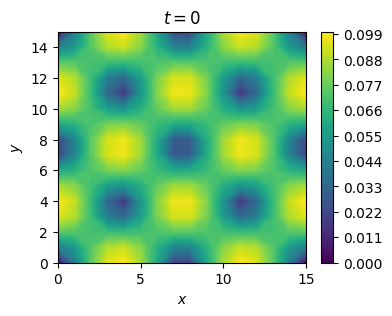

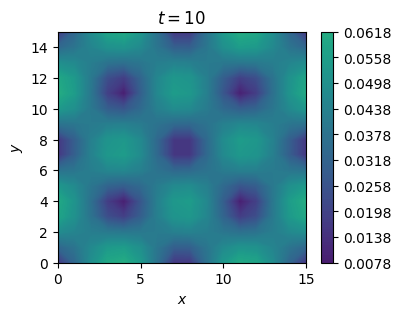

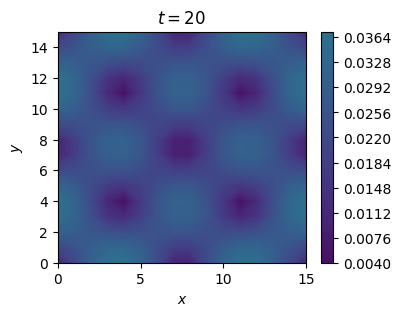

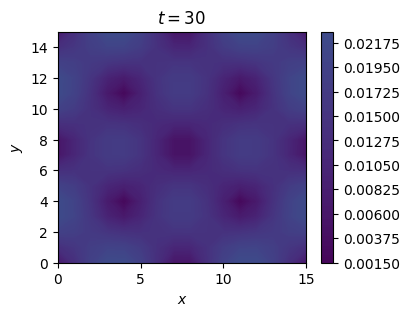

In [10]:
x = jnp.arange(Nx)
y = jnp.arange(Ny)
x, y = jnp.meshgrid(x, y, indexing='ij')

fit, total_KE = [], []
A_ij, B_ijk = get_matrix(omega)
for it in range(Nt):
    fit.append(fi)
    rhoit, uxit, uyit = get_macro_quantities(fi)
    umit = jnp.sqrt(uxit**2 + uyit**2)
    local_KE = 0.5 * rhoit * (uxit**2 + uyit**2) * dx * dy
    total_KE.append(jnp.sum(local_KE))
    
    fi = collision_BGK(fi, A_ij, B_ijk)
    fi = streaming(fi)
    
    if it % 10 == 0:
        plt.figure(figsize=(4, 3))
        contour = plt.contourf(x, y, umit, levels=100, cmap='viridis', vmin=0.0, vmax=0.1)
        plt.colorbar(contour)
        plt.title(f"$t = {it}$")
        plt.xlabel("$x$")
        plt.ylabel("$y$")
        plt.show()

In [11]:
jnp.save("fi_LBM_taylor", fit)
jnp.save("fi_LBM_TKE", total_KE)